In [1]:
# Dependencies
import os, os.path
import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import seaborn as sns



from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
plt.style.use('fivethirtyeight')

In [3]:
images_path = "..\\leedsbutterfly\\images\\"
file = os.listdir(images_path)

In [4]:
# Get images and labels into lists
images = []
labels = []

img_shape = (220, 220, 3)

for img in file:
    label = int(img[:3]) # First three digits will identify species (001, 002)
    labels.append(label)
    img_location = os.path.join(images_path, img)
    img_array = cv2.imread(img_location)[:,:,::-1] # Automatically converts from BGR to RGB
    img_array = cv2.resize(img_array, img_shape[:2])
    images.append(img_array)

In [181]:
images = np.array(images)

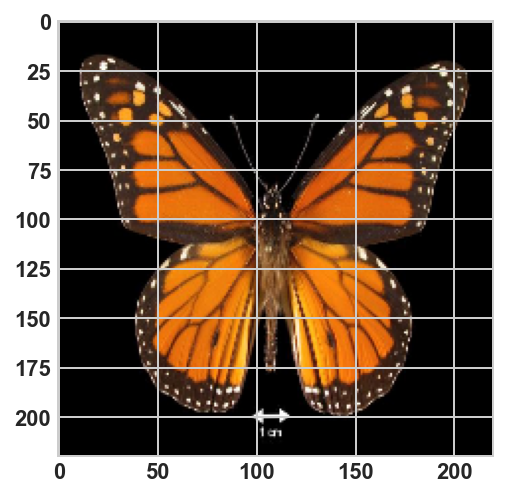

In [184]:
plt.imshow(images[1])

In [6]:
dict_labels = {'001': 'Danaus_plexippus', 
               '002': 'Heliconius_charitonius', 
               '003': 'Heliconius_erato', 
               '004': 'Junonia_coenia', 
               '005': 'Lycaena_phlaeas', 
               '006': 'Nymphalis_antiopa', 
               '007': 'Papilio_cresphontes', 
               '008': 'Pieris_rapae', 
               '009': 'Vanessa_atalanta', 
               '0010': 'Vanessa_cardui'}

In [7]:
# Sets label for every picture
list_labels=[]
for i in labels:
    new_label=dict_labels['00'+str(i)]
    list_labels.append(new_label)

In [8]:
print(list_labels[233:239])

['Heliconius_erato', 'Heliconius_erato', 'Heliconius_erato', 'Junonia_coenia', 'Junonia_coenia', 'Junonia_coenia']


In [9]:
type(images), type(labels), type(dict_labels)

(list, list, dict)

In [10]:
# Convert images list to np.array 
imgs_array = np.array(images)
imgs_array = imgs_array / 255.0
imgs_array.max()

1.0

In [11]:
imgs_array.shape

(832, 220, 220, 3)

### Visualize Data

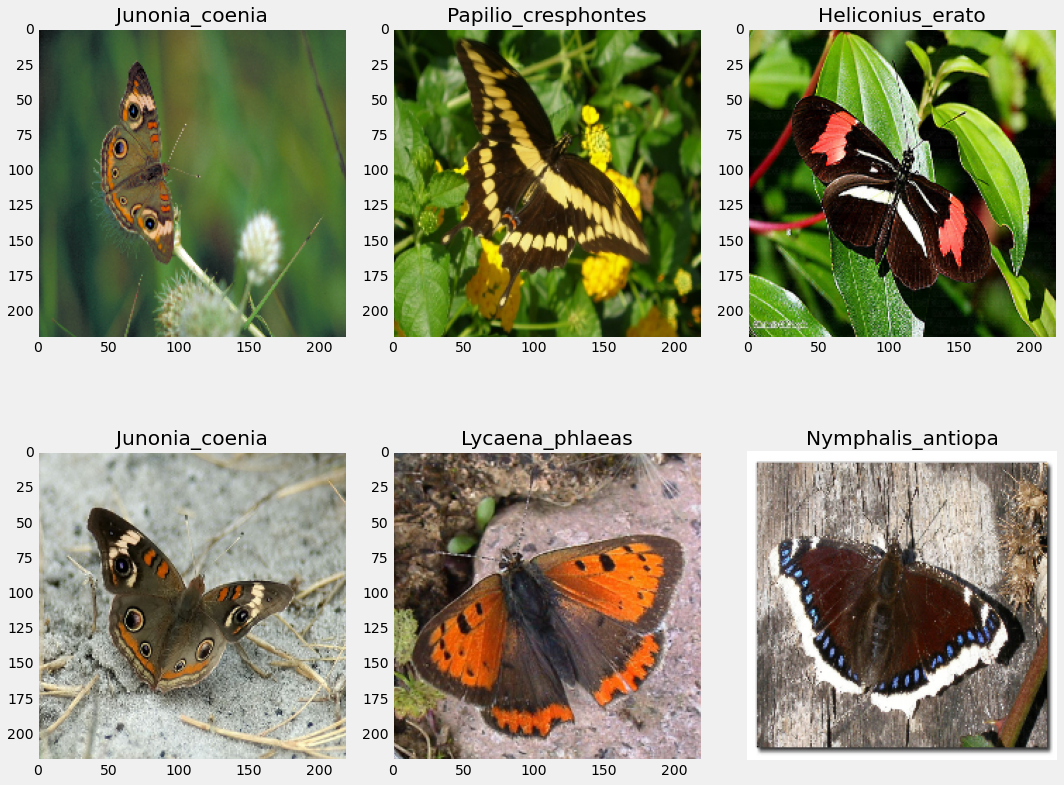

In [12]:
# 6 subplots of random butterflies with their associated species
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,12)

for i in range(2):
    for j in range(3):
        random_image = np.random.randint(0, len(labels))
        ax[i,j].imshow(imgs_array[random_image])
        ax[i,j].set_title(str(list_labels[random_image]))
        ax[i,j].grid(None)
plt.axis('off')
plt.tight_layout()

C:\Users\danny\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


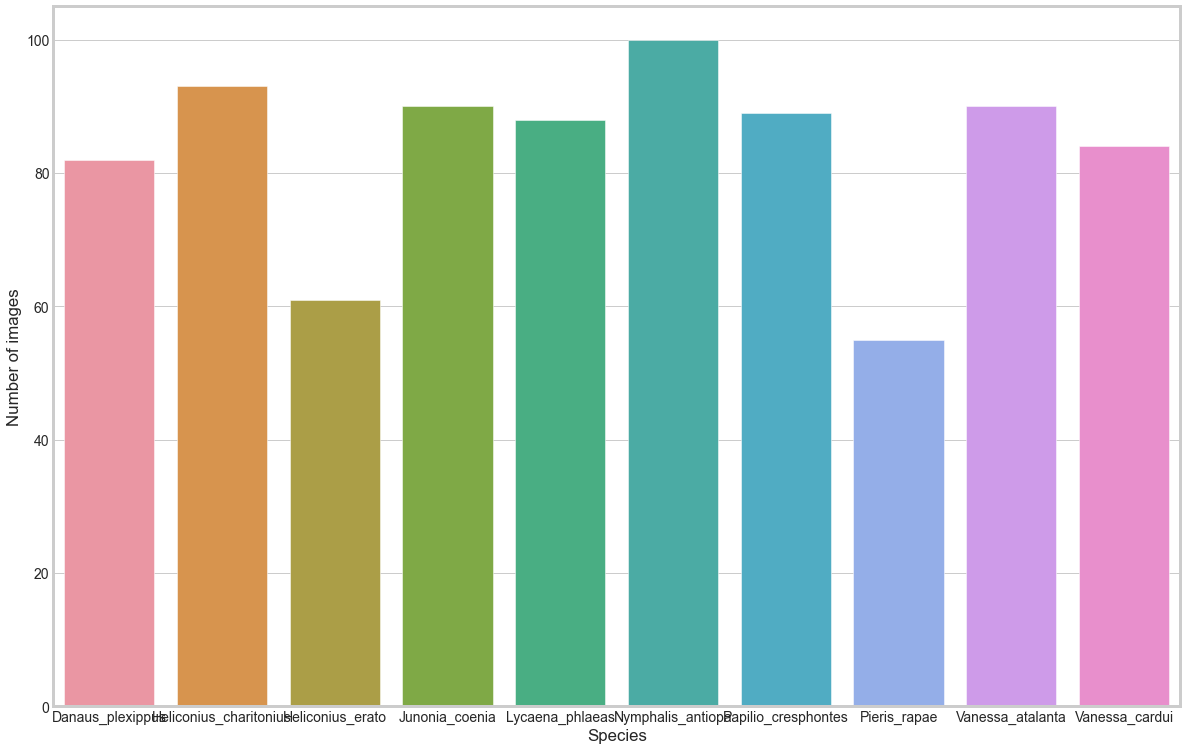

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,12))
fig=sns.countplot(list_labels)
plt.xlabel('Species')
plt.ylabel('Number of images')
plt.show()

### One hot encoding

Converting labels into a set of 10 for the neural network

Example: format \[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.\] would be class number 2

In [14]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [15]:
encoder = LabelEncoder()
Y = encoder.fit_transform(list_labels)

In [16]:
y = to_categorical(Y)

In [17]:
Y.shape, y.shape

((832,), (832, 10))

In [18]:
y[150]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(imgs_array, y, random_state=42, test_size=0.2)

In [21]:
print('One hot label:', y_train[11])

One hot label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### Double checking work so far

In [22]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
print('x_train_shape:', x_train.shape)
print('y_train_shape:', y_train.shape)
print('x_test_shape:', x_test.shape)
print('y_test_shape:', y_test.shape)

x_train_shape: (665, 220, 220, 3)
y_train_shape: (665, 10)
x_test_shape: (167, 220, 220, 3)
y_test_shape: (167, 10)


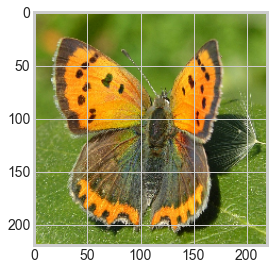

In [24]:
# Check an image with its label
index = 10
img = plt.imshow(x_train[index])

In [25]:
label_number = np.argmax(y_train[index])

print('The image label:', label_number)

The image label: 4


In [26]:
# On one line
print('The image label:', np.argmax(y_train[index]))

The image label: 4


In [27]:
# Get the classification of the image
classification = ['Danaus plexippus',
                  'Heliconius charitonius',
                  'Heliconius erato',
                  'Junonia coenia',
                  'Lycaena phlaeas',
                  'Nymphalis antiopa',
                  'Papilio cresphontes',
                  'Pieris rapae',
                  'Vanessa atalanta',
                  'Vanessa cardui']

In [28]:
print('Image class is:', classification[np.argmax(y_train[index])])

Image class is: Lycaena phlaeas


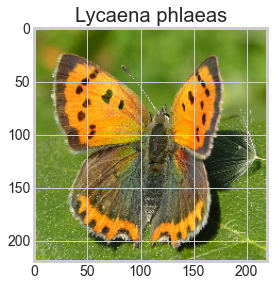

In [29]:
# Check an image and label together
index = 10
plt.figure()
plt.title(classification[np.argmax(y_train[index])])
img = plt.imshow(x_train[index])

### Import model on rerun of code

In [30]:
from tensorflow.keras.models import load_model

In [31]:
dense_model = load_model('dense_model.h5')

### Create the model

In [136]:
# Create the model
model = Sequential()

# First layer needs an input shape, 32 filters
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(220,220,3))) # (5,5) kernel size

# Pooling layer
model.add(MaxPooling2D(pool_size=(2,2))) # Two-by-two pixel filter gets max element from the feature maps

# Second convolution layer, 32 filters
model.add(Conv2D(32, (5,5), activation='relu'))

# Second pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# # Third convolution layer, 64 filters
# model.add(Conv2D(64, (5,5), activation='relu'))

# # Third pooling layer
# model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer
model.add(Flatten()) # Reduce the dimensionality to a linear array

# Layer with 1000 neurons
model.add(Dense(1000, activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# Layer with 500 neurons
model.add(Dense(500, activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# Layer with 250 neurons
model.add(Dense(250, activation='relu'))

# Layer with 10 neurons
# Softmax assigns decimal probabilities to each class
model.add(Dense(len(y[1]), activation='softmax')) # y[1] is a list of labels, so 10 categories

In [253]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 216, 216, 32)      2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 104, 104, 32)      25632     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              86529000  
_________________________________________________________________
dropout_16 (Dropout)         (None, 1000)             

In [137]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Fit the model

In [115]:
from tensorflow.keras.callbacks import EarlyStopping

In [116]:
early_stop = early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [142]:
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=25,
                    callbacks=early_stop,
                    validation_split=0.2)

Epoch 1/25
9/9 [==============================] - 15s 2s/step - loss: 4.1379 - accuracy: 0.0977 - val_loss: 2.2882 - val_accuracy: 0.1654
Epoch 2/25
9/9 [==============================] - 15s 2s/step - loss: 2.2922 - accuracy: 0.1560 - val_loss: 2.2594 - val_accuracy: 0.2782
Epoch 3/25
9/9 [==============================] - 15s 2s/step - loss: 2.1833 - accuracy: 0.1861 - val_loss: 2.0308 - val_accuracy: 0.3008
Epoch 4/25
9/9 [==============================] - 15s 2s/step - loss: 1.9390 - accuracy: 0.2650 - val_loss: 1.8286 - val_accuracy: 0.3233
Epoch 5/25
9/9 [==============================] - 15s 2s/step - loss: 1.6664 - accuracy: 0.3929 - val_loss: 1.6710 - val_accuracy: 0.3985
Epoch 6/25
9/9 [==============================] - 15s 2s/step - loss: 1.4611 - accuracy: 0.4756 - val_loss: 1.6369 - val_accuracy: 0.3985
Epoch 7/25
9/9 [==============================] - 15s 2s/step - loss: 1.0754 - accuracy: 0.6316 - val_loss: 1.2734 - val_accuracy: 0.5188
Epoch 8/25
9/9 [==================

### Evaluate the model

In [144]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 122ms/step - loss: 1.6916 - accuracy: 0.5629


[1.6915688514709473, 0.5628742575645447]

### Visualize model's accuracy

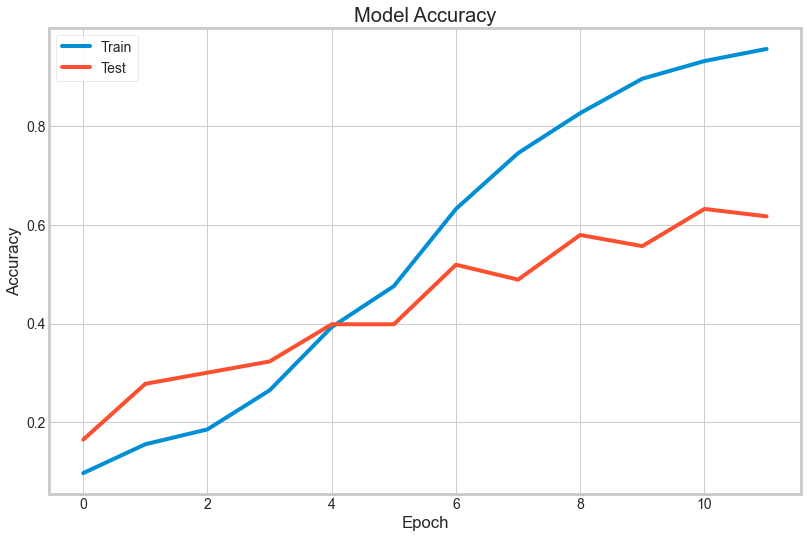

In [147]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

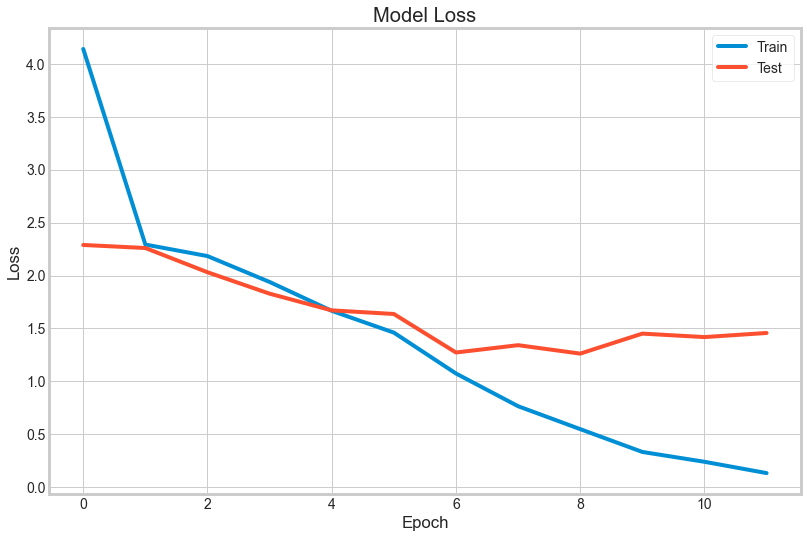

In [148]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

### Test the model

**Load a downloaded image**

In [176]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

In [177]:
desktop = 'C:\\Users\\danny\\OneDrive\\Desktop\\'

In [183]:
img_path = desktop+'nymphalis.jpg'
new_image = plt.imread(img_path)

In [184]:
type(img)

numpy.ndarray

In [185]:
img.shape

(179, 282, 3)

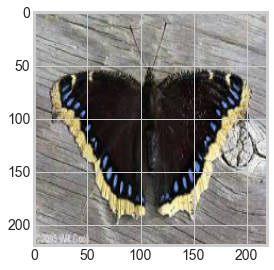

In [187]:
# Resize the image
resized_image = resize(new_image, img_shape)
img = plt.imshow(resized_image)

In [188]:
# Get predictions
predictions = model.predict(np.array([resized_image]))

# Show predictions
predictions

array([[9.6846449e-08, 1.7712784e-10, 3.2443135e-09, 9.3638511e-05,
        1.4439229e-06, 9.9967754e-01, 2.4048907e-07, 4.6254218e-09,
        2.2454443e-04, 2.4929698e-06]], dtype=float32)

In [190]:
list_index = [0,1,2,3,4,5,6,7,8,9]
x = predictions

# Simple swapping function to sort the predictions least -> greatest
for i in range(10):
    for j in range(10):
        if x[0][list_index[i]] > x[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp
            
# labels in order
print(list_index)

[5, 8, 3, 9, 4, 6, 0, 7, 2, 1]


In [191]:
# print top 3 predictions
for i in range(3):
    print(classification[list_index[i]], ':', round(predictions[0][list_index[i]] * 100, 2), '%')

Nymphalis antiopa : 99.97 %
Vanessa atalanta : 0.02 %
Junonia coenia : 0.01 %


### Visualizations

**Get predictions on test data**

In [36]:
Y_pred = model.predict(x_test)

NameError: name 'model' is not defined

In [207]:
# y_pred will just be a single digit 0-9
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([7, 9, 8, 6, 6, 8, 8, 1, 3, 1, 9, 1, 6, 2, 0, 4, 3, 6, 8, 6, 8, 0,
       1, 6, 3, 1, 1, 5, 5, 3, 7, 4, 6, 6, 6, 6, 4, 6, 0, 0, 5, 7, 0, 9,
       3, 8, 8, 7, 5, 4, 3, 3, 4, 8, 6, 8, 8, 8, 2, 5, 8, 9, 9, 1, 3, 2,
       6, 8, 5, 8, 4, 0, 4, 8, 6, 8, 1, 9, 0, 0, 9, 6, 2, 2, 2, 6, 1, 0,
       0, 9, 6, 8, 3, 9, 3, 3, 3, 3, 6, 8, 8, 9, 7, 6, 0, 0, 8, 3, 7, 4,
       1, 4, 0, 3, 3, 3, 3, 5, 8, 9, 1, 8, 6, 1, 1, 6, 3, 9, 4, 1, 6, 4,
       6, 8, 3, 4, 8, 2, 1, 3, 8, 7, 8, 3, 8, 3, 6, 8, 5, 7, 0, 3, 8, 1,
       4, 4, 7, 1, 0, 8, 6, 7, 2, 7, 8, 8, 6], dtype=int64)

In [204]:
y_pred.size

167

**Get true values on test data**

In [220]:
Y_true = []

for one_hot in y_test:
    Y_true.append(np.argmax(one_hot))

In [221]:
len(Y_true)

167

In [229]:
print(Y_true)

[7, 9, 3, 6, 1, 8, 9, 1, 3, 6, 9, 1, 3, 2, 0, 4, 3, 3, 9, 6, 5, 0, 2, 6, 3, 6, 1, 5, 8, 4, 7, 4, 1, 6, 0, 6, 5, 6, 0, 0, 5, 7, 0, 9, 5, 0, 9, 7, 5, 2, 8, 9, 4, 3, 6, 8, 8, 5, 6, 5, 9, 4, 8, 1, 8, 2, 7, 8, 5, 5, 8, 0, 4, 3, 0, 9, 2, 9, 0, 0, 9, 6, 5, 2, 2, 5, 2, 0, 0, 1, 6, 3, 9, 1, 3, 9, 4, 3, 6, 3, 9, 9, 7, 1, 0, 0, 9, 3, 7, 7, 1, 4, 0, 9, 8, 9, 4, 5, 5, 8, 1, 0, 2, 1, 3, 6, 3, 8, 4, 1, 8, 7, 0, 8, 9, 4, 8, 0, 6, 3, 8, 7, 8, 4, 8, 5, 6, 8, 5, 7, 0, 9, 8, 1, 4, 4, 5, 9, 0, 8, 5, 7, 2, 7, 5, 9, 6]


In [225]:
type(Y_true)

list

In [226]:
y_true = np.array(Y_true)

In [230]:
y_true, type(y_true)

(array([7, 9, 3, 6, 1, 8, 9, 1, 3, 6, 9, 1, 3, 2, 0, 4, 3, 3, 9, 6, 5, 0,
        2, 6, 3, 6, 1, 5, 8, 4, 7, 4, 1, 6, 0, 6, 5, 6, 0, 0, 5, 7, 0, 9,
        5, 0, 9, 7, 5, 2, 8, 9, 4, 3, 6, 8, 8, 5, 6, 5, 9, 4, 8, 1, 8, 2,
        7, 8, 5, 5, 8, 0, 4, 3, 0, 9, 2, 9, 0, 0, 9, 6, 5, 2, 2, 5, 2, 0,
        0, 1, 6, 3, 9, 1, 3, 9, 4, 3, 6, 3, 9, 9, 7, 1, 0, 0, 9, 3, 7, 7,
        1, 4, 0, 9, 8, 9, 4, 5, 5, 8, 1, 0, 2, 1, 3, 6, 3, 8, 4, 1, 8, 7,
        0, 8, 9, 4, 8, 0, 6, 3, 8, 7, 8, 4, 8, 5, 6, 8, 5, 7, 0, 9, 8, 1,
        4, 4, 5, 9, 0, 8, 5, 7, 2, 7, 5, 9, 6], dtype=int64),
 numpy.ndarray)

**Confusion Matrix**

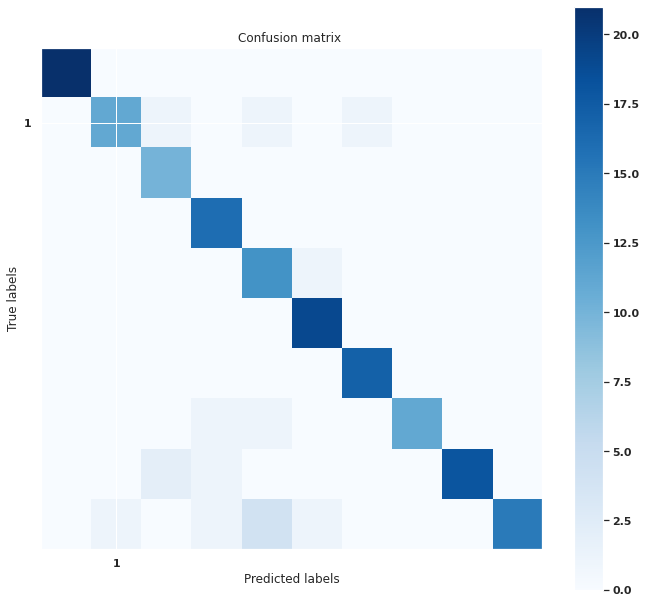

In [492]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([1], [1])
plt.yticks([1], [1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**Classification Report**

In [239]:
clf_report = classification_report(y_true, y_pred, target_names=classification)
clf_report

'                        precision    recall  f1-score   support\n\n      Danaus plexippus       1.00      0.71      0.83        21\nHeliconius charitonius       0.53      0.64      0.58        14\n      Heliconius erato       0.62      0.50      0.56        10\n        Junonia coenia       0.33      0.50      0.40        16\n       Lycaena phlaeas       0.64      0.64      0.64        14\n     Nymphalis antiopa       0.88      0.37      0.52        19\n   Papilio cresphontes       0.50      0.76      0.60        17\n          Pieris rapae       0.91      0.77      0.83        13\n      Vanessa atalanta       0.38      0.57      0.45        21\n        Vanessa cardui       0.50      0.27      0.35        22\n\n              accuracy                           0.56       167\n             macro avg       0.63      0.57      0.58       167\n          weighted avg       0.63      0.56      0.57       167\n'

In [240]:
# Output clf_rerport as dict so we can use convert to dataframe for sns.heatmap
clf_report_dict = classification_report(y_true, y_pred, target_names=classification, output_dict=True)

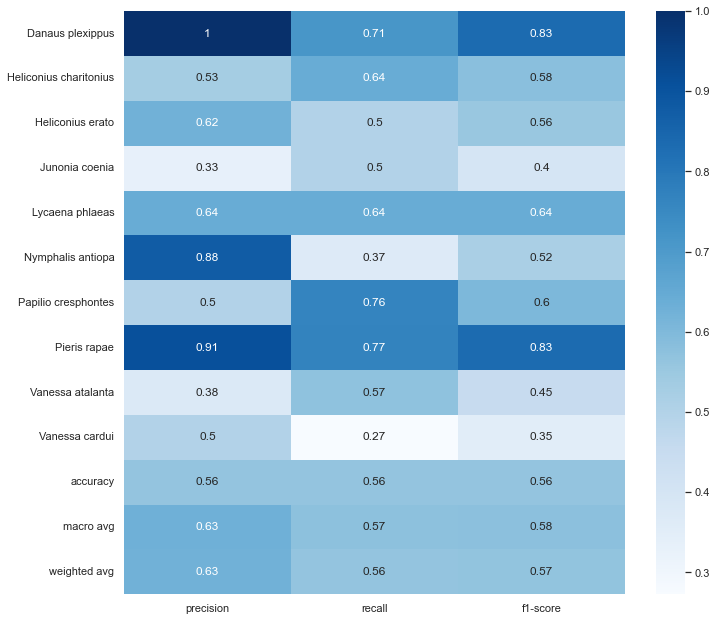

In [286]:
sns.heatmap(pd.DataFrame(clf_report_dict).iloc[:-1, :].T, annot=True, cmap="Blues")
sns.set(rc = {'figure.figsize':(10,10)})

### Repeat steps using DenseNet121

In [109]:
from tensorflow.keras.applications import DenseNet121

In [110]:
# Using pre-trained imagenet weights
dense_mod = DenseNet121(weights='imagenet', input_shape=img_shape, include_top=False)

In [111]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in dense_mod.layers:
    layer.trainable = False

In [112]:
x = Flatten()(dense_mod.output)
outputs = Dense(len(y[1]), activation='softmax')(x)

In [113]:
dense_model = Model(inputs=dense_mod.input, outputs=outputs)

dense_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 110, 110, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 110, 110, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [117]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [118]:
dense_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [119]:
dense_history = dense_model.fit(x_train,
                                y_train,
                                batch_size=64,
                                epochs=25,
                                callbacks=early_stop,
                                validation_split=0.2)

Epoch 1/25
9/9 [==============================] - 24s 2s/step - loss: 5.8407 - accuracy: 0.4211 - val_loss: 1.0781 - val_accuracy: 0.7820
Epoch 2/25
9/9 [==============================] - 21s 2s/step - loss: 0.3762 - accuracy: 0.9248 - val_loss: 0.1480 - val_accuracy: 0.9624
Epoch 3/25
9/9 [==============================] - 21s 2s/step - loss: 0.1003 - accuracy: 0.9868 - val_loss: 0.0915 - val_accuracy: 0.9850
Epoch 4/25
9/9 [==============================] - 21s 2s/step - loss: 0.0232 - accuracy: 0.9962 - val_loss: 0.0717 - val_accuracy: 0.9925
Epoch 5/25
9/9 [==============================] - 22s 3s/step - loss: 4.0364e-05 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 0.9850
Epoch 6/25
9/9 [==============================] - 21s 2s/step - loss: 1.5623e-04 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.9850
Epoch 7/25
9/9 [==============================] - 21s 2s/step - loss: 1.9178e-04 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9850


In [120]:
dense_model.evaluate(x_test, y_test)

6/6 [==============================] - 5s 883ms/step - loss: 0.0068 - accuracy: 0.9940


[0.006762565113604069, 0.9940119981765747]

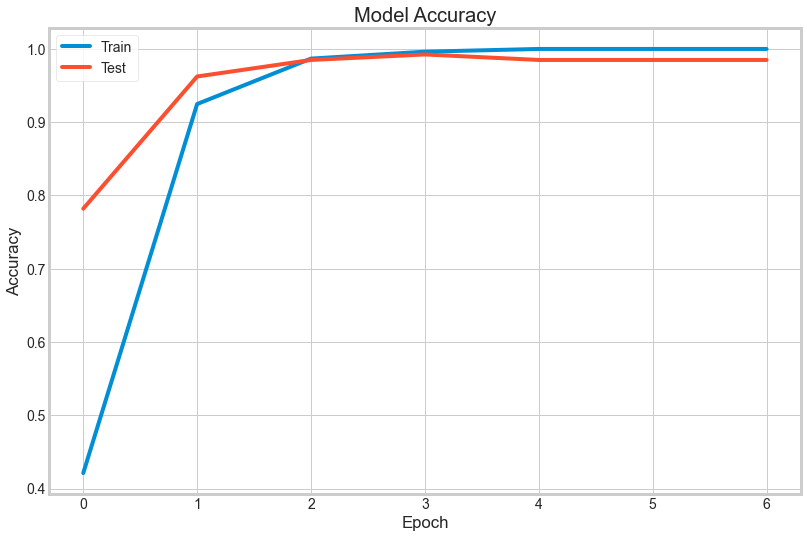

In [121]:
plt.figure(figsize=(12,8))
plt.plot(dense_history.history['accuracy'])
plt.plot(dense_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

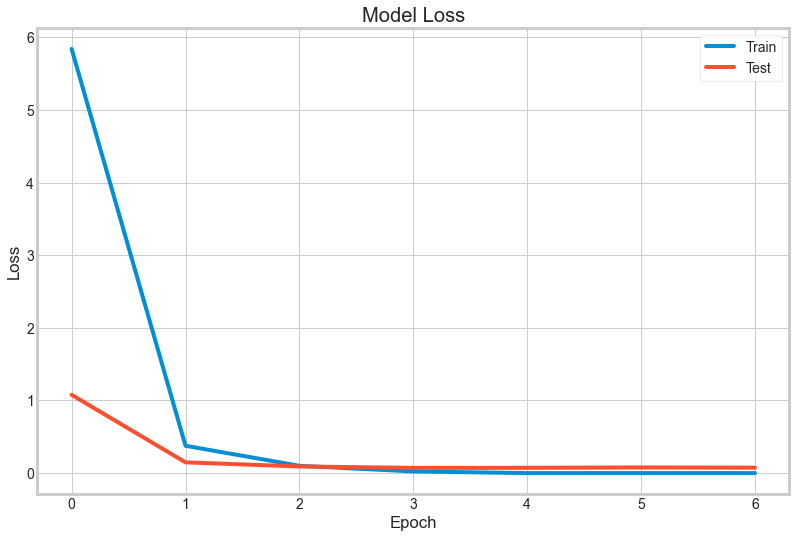

In [122]:
plt.figure(figsize=(12,8))
plt.plot(dense_history.history['loss'])
plt.plot(dense_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

### DenseNet visualizations

In [123]:
Y_pred = dense_model.predict(x_test)

In [124]:
# y_pred will just be a single digit 0-9
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([7, 9, 3, 6, 1, 8, 9, 1, 3, 6, 9, 1, 3, 2, 0, 4, 3, 3, 9, 6, 5, 0,
       2, 6, 3, 6, 1, 5, 8, 4, 7, 0, 1, 6, 0, 6, 5, 6, 0, 0, 5, 7, 0, 9,
       5, 0, 9, 7, 5, 2, 8, 9, 4, 3, 6, 8, 8, 5, 6, 5, 9, 4, 8, 1, 8, 2,
       7, 8, 5, 5, 8, 0, 4, 3, 0, 9, 2, 9, 0, 0, 9, 6, 5, 2, 2, 5, 2, 0,
       0, 1, 6, 3, 9, 1, 3, 9, 4, 3, 6, 3, 9, 9, 7, 1, 0, 0, 9, 3, 7, 7,
       1, 4, 0, 9, 8, 9, 4, 5, 5, 8, 1, 0, 2, 1, 3, 6, 3, 8, 4, 1, 8, 7,
       0, 8, 9, 4, 8, 0, 6, 3, 8, 7, 8, 4, 8, 5, 6, 8, 5, 7, 0, 9, 8, 1,
       4, 4, 5, 9, 0, 8, 5, 7, 2, 7, 5, 9, 6], dtype=int64)

In [125]:
Y_true = []

for one_hot in y_test:
    Y_true.append(np.argmax(one_hot))

In [126]:
y_true = np.array(Y_true)

**DenseNet Confusion Matrix**

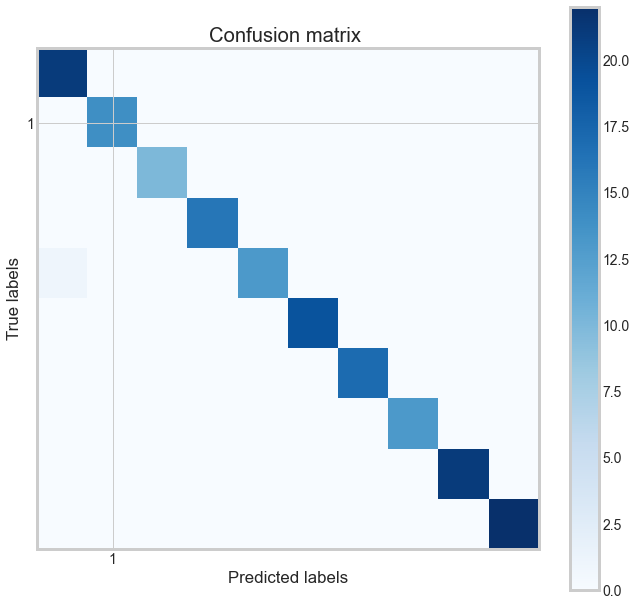

In [127]:
cm_dense = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm_dense, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([1], [1])
plt.yticks([1], [1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**DenseNet Classification Report**

In [128]:
clf_report_dense = classification_report(y_true, y_pred, target_names=classification)
clf_report_dense

'                        precision    recall  f1-score   support\n\n      Danaus plexippus       0.95      1.00      0.98        21\nHeliconius charitonius       1.00      1.00      1.00        14\n      Heliconius erato       1.00      1.00      1.00        10\n        Junonia coenia       1.00      1.00      1.00        16\n       Lycaena phlaeas       1.00      0.93      0.96        14\n     Nymphalis antiopa       1.00      1.00      1.00        19\n   Papilio cresphontes       1.00      1.00      1.00        17\n          Pieris rapae       1.00      1.00      1.00        13\n      Vanessa atalanta       1.00      1.00      1.00        21\n        Vanessa cardui       1.00      1.00      1.00        22\n\n              accuracy                           0.99       167\n             macro avg       1.00      0.99      0.99       167\n          weighted avg       0.99      0.99      0.99       167\n'

In [129]:
clf_report_dense_dict = classification_report(y_true, y_pred, target_names=classification, output_dict=True)

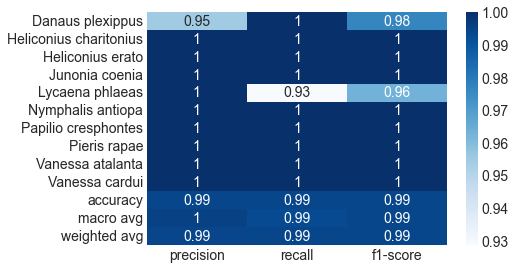

In [130]:
sns.heatmap(pd.DataFrame(clf_report_dense_dict).iloc[:-1, :].T, annot=True, cmap="Blues")
sns.set(rc = {'figure.figsize':(10,10)})

In [413]:
np.save('dense_history.npy',dense_history.history)

In [414]:
dense_model.save('dense_model.h5')

### Repeat steps using ResNet50V2

In [321]:
from tensorflow.keras.applications import ResNet50V2

In [322]:
# Using pre-trained imagenet weights
efficient_mod = ResNet50V2(weights='imagenet', input_shape=img_shape, include_top=False)

94683136/94668760 [==============================] - 14s 0us/step


In [323]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in efficient_mod.layers:
    layer.trainable = False

In [324]:
x = Flatten()(efficient_mod.output)
outputs = Dense(len(y[1]), activation='softmax')(x)

In [325]:
efficient_model = Model(inputs=efficient_mod.input, outputs=outputs)

efficient_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [326]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [327]:
efficient_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [328]:
efficient_history = efficient_model.fit(x_train,
                                        y_train,
                                        batch_size=64,
                                        epochs=25,
                                        callbacks=early_stop,
                                        validation_split=0.2)

Epoch 1/25
9/9 [==============================] - 18s 2s/step - loss: 3.7253 - accuracy: 0.6523 - val_loss: 0.1590 - val_accuracy: 0.9549
Epoch 2/25
9/9 [==============================] - 16s 2s/step - loss: 0.1956 - accuracy: 0.9831 - val_loss: 0.4177 - val_accuracy: 0.9474
Epoch 3/25
9/9 [==============================] - 16s 2s/step - loss: 0.1560 - accuracy: 0.9831 - val_loss: 0.4912 - val_accuracy: 0.9699
Epoch 4/25
9/9 [==============================] - 16s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1108 - val_accuracy: 0.9925
Epoch 5/25
9/9 [==============================] - 16s 2s/step - loss: 9.9234e-04 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9925
Epoch 6/25
9/9 [==============================] - 15s 2s/step - loss: 1.3108e-07 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9925
Epoch 7/25
9/9 [==============================] - 15s 2s/step - loss: 9.1871e-08 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9925
Epoch 8/25
9/9 [======

In [329]:
efficient_model.evaluate(x_test, y_test)

6/6 [==============================] - 4s 670ms/step - loss: 1.6626 - accuracy: 0.9042


[1.662551760673523, 0.9041916131973267]

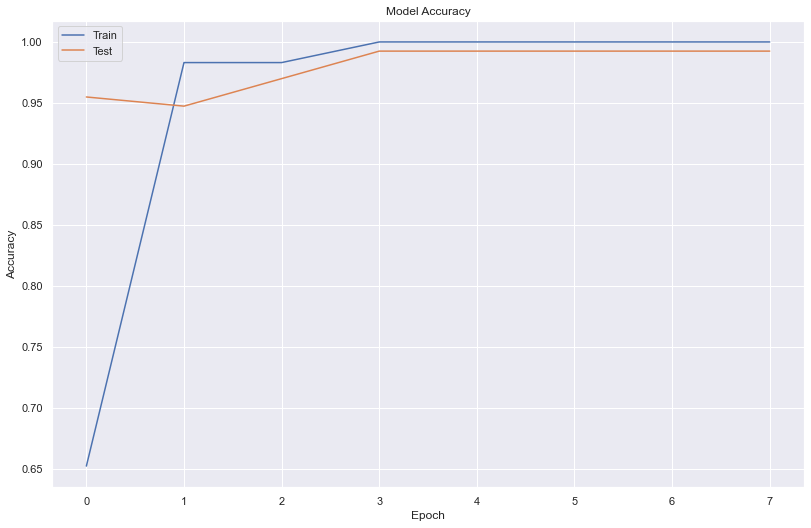

In [330]:
plt.figure(figsize=(12,8))
plt.plot(efficient_history.history['accuracy'])
plt.plot(efficient_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

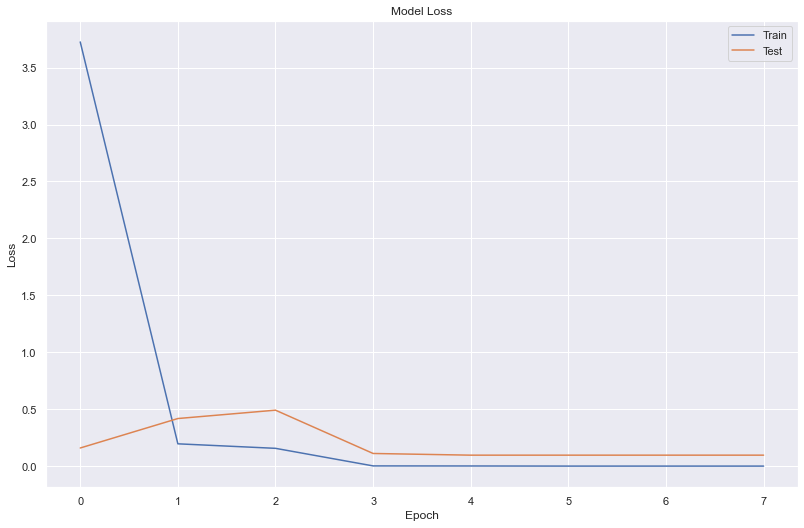

In [331]:
plt.figure(figsize=(12,8))
plt.plot(efficient_history.history['loss'])
plt.plot(efficient_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

### ResNet Visualizations

In [37]:
Y_pred = efficient_model.predict(x_test)

NameError: name 'efficient_model' is not defined

In [333]:
# y_pred will just be a single digit 0-9
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([7, 9, 3, 6, 2, 8, 4, 1, 3, 6, 9, 1, 3, 2, 0, 4, 3, 3, 9, 6, 5, 0,
       2, 6, 3, 6, 1, 5, 8, 4, 7, 4, 1, 6, 0, 6, 5, 6, 0, 0, 5, 7, 0, 9,
       5, 0, 9, 7, 5, 2, 2, 9, 5, 3, 6, 8, 8, 5, 6, 5, 9, 4, 8, 1, 8, 2,
       3, 8, 5, 5, 8, 0, 4, 3, 0, 9, 2, 9, 0, 0, 1, 6, 5, 2, 2, 5, 2, 0,
       0, 1, 6, 3, 5, 6, 3, 9, 4, 3, 6, 3, 9, 4, 7, 4, 0, 0, 9, 3, 7, 4,
       1, 4, 0, 9, 2, 4, 4, 5, 5, 8, 1, 0, 2, 1, 3, 6, 3, 8, 4, 1, 3, 7,
       0, 8, 9, 4, 8, 0, 6, 3, 8, 7, 8, 4, 8, 5, 6, 8, 5, 7, 0, 9, 8, 1,
       4, 4, 5, 4, 0, 8, 5, 7, 2, 7, 5, 3, 6], dtype=int64)

In [334]:
Y_true = []

for one_hot in y_test:
    Y_true.append(np.argmax(one_hot))

In [335]:
y_true = np.array(Y_true)

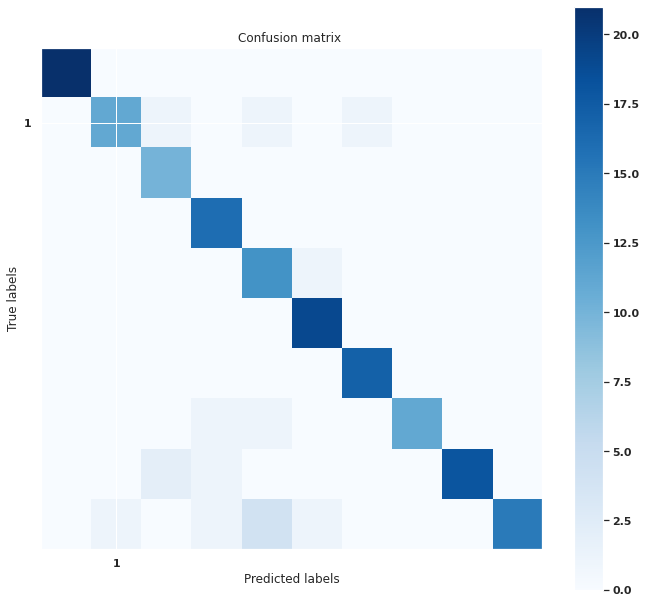

In [493]:
cm_efficient = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm_efficient, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([1], [1])
plt.yticks([1], [1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [337]:
clf_report_efficient = classification_report(y_true, y_pred, target_names=classification)
clf_report_efficient

'                        precision    recall  f1-score   support\n\n      Danaus plexippus       1.00      1.00      1.00        21\nHeliconius charitonius       0.92      0.79      0.85        14\n      Heliconius erato       0.77      1.00      0.87        10\n        Junonia coenia       0.84      1.00      0.91        16\n       Lycaena phlaeas       0.68      0.93      0.79        14\n     Nymphalis antiopa       0.90      1.00      0.95        19\n   Papilio cresphontes       0.94      1.00      0.97        17\n          Pieris rapae       1.00      0.85      0.92        13\n      Vanessa atalanta       1.00      0.86      0.92        21\n        Vanessa cardui       1.00      0.68      0.81        22\n\n              accuracy                           0.90       167\n             macro avg       0.91      0.91      0.90       167\n          weighted avg       0.92      0.90      0.90       167\n'

In [338]:
clf_report_efficient_dict = classification_report(y_true, y_pred, target_names=classification, output_dict=True)

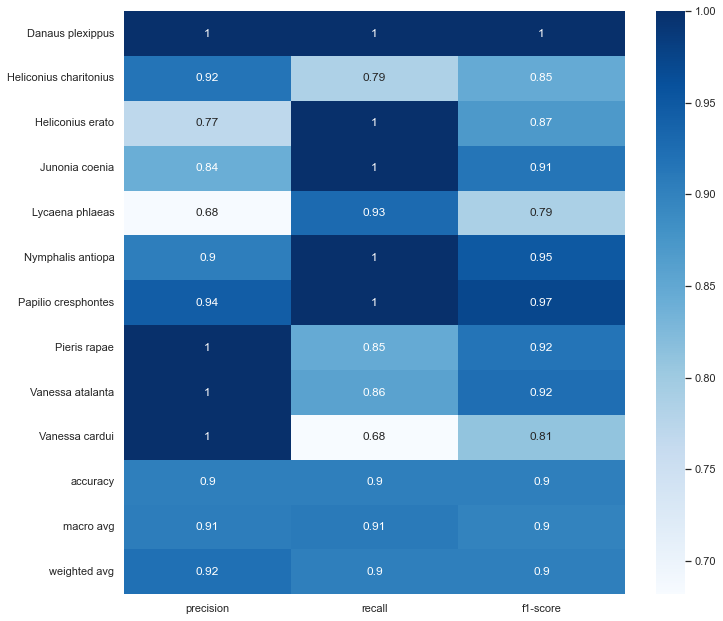

In [339]:
sns.heatmap(pd.DataFrame(clf_report_efficient_dict).iloc[:-1, :].T, annot=True, cmap="Blues")
sns.set(rc = {'figure.figsize':(10,10)})

### Data Visualization using PCA

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

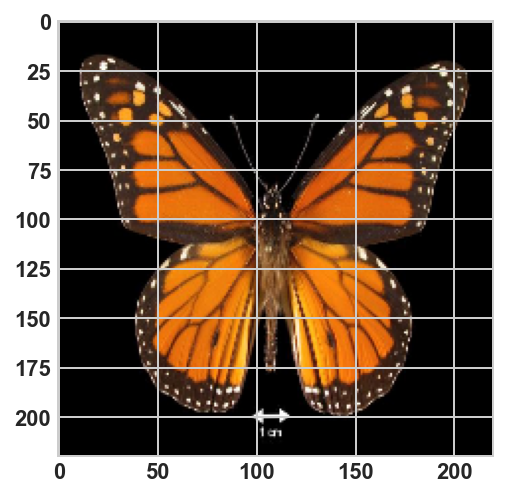

In [169]:
plt.imshow(images[1])

In [232]:
# Flatten the images (reshape dimensions from 3 to 1)
x_train.shape

# # Trying with test too
# x_test.shape

(665, 220, 220, 3)

In [233]:
flattened = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
flattened

# flattened = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
# flattened

145200

In [234]:
x_train_flat = x_train.reshape(-1, flattened)

# x_test_flat = x_test.reshape(-1, flattened)

In [235]:
x_train_flat.shape

# x_test_flat.shape

(665, 145200)

In [236]:
scaler = StandardScaler()
train_x = scaler.fit_transform(x_train_flat)
test_x = scaler.fit_transform(y_train)

# scaler = StandardScaler()
# train_x = scaler.fit_transform(x_test_flat)
# test_x = scaler.fit_transform(y_test)

In [237]:
print(classification[np.argmax(test_x[1])])

Lycaena phlaeas


In [238]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_flat)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

principalDf = pd.concat([principalDf],axis = 1,ignore_index=True)

principalDf.columns = ['Principal Component 1', 'Principal Component 2'] 

In [239]:
len(train_x)

665

<AxesSubplot:xlabel='Principal Component 1', ylabel='Principal Component 2'>

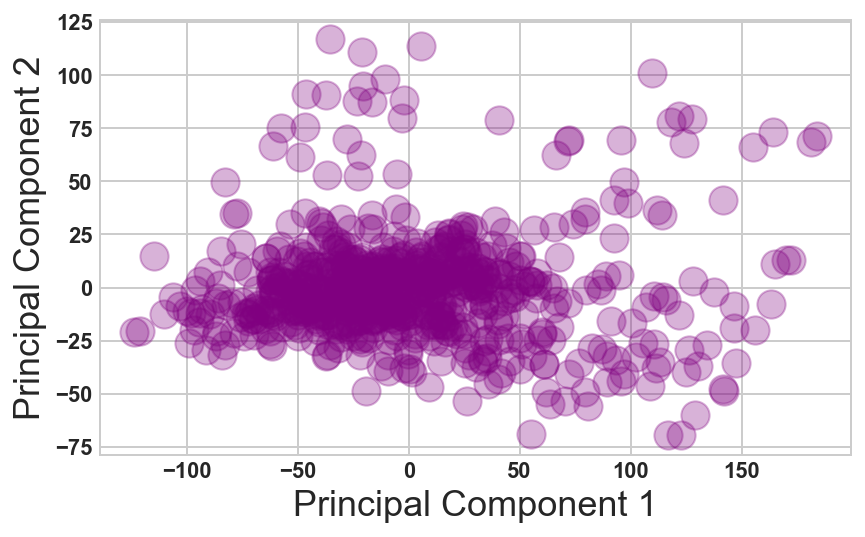

In [240]:
# give a list to the marker argument
sns.regplot(x=principalDf["Principal Component 1"], y=principalDf["Principal Component 2"],
            fit_reg=False, scatter_kws={"color":"purple","alpha":0.3,"s":200} )

In [158]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.27065704 0.06068122]


<Figure size 936x720 with 0 Axes>

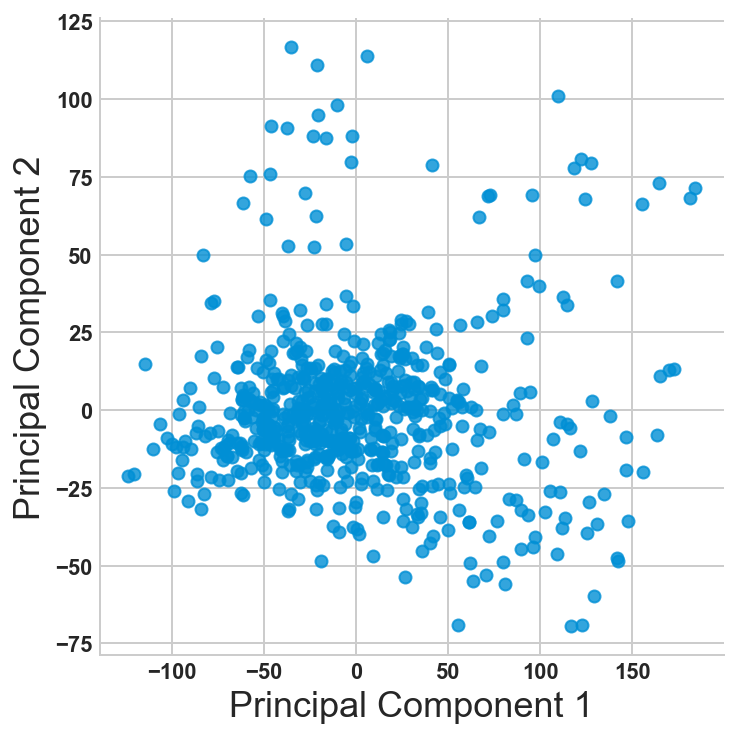

<Figure size 936x720 with 0 Axes>

In [159]:
sns.lmplot( x='Principal Component 1', y='Principal Component 2', data=principalDf, fit_reg=False, 
           legend=False, palette="Blues")
plt.figure(figsize=(13,10))

C:\Users\danny\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


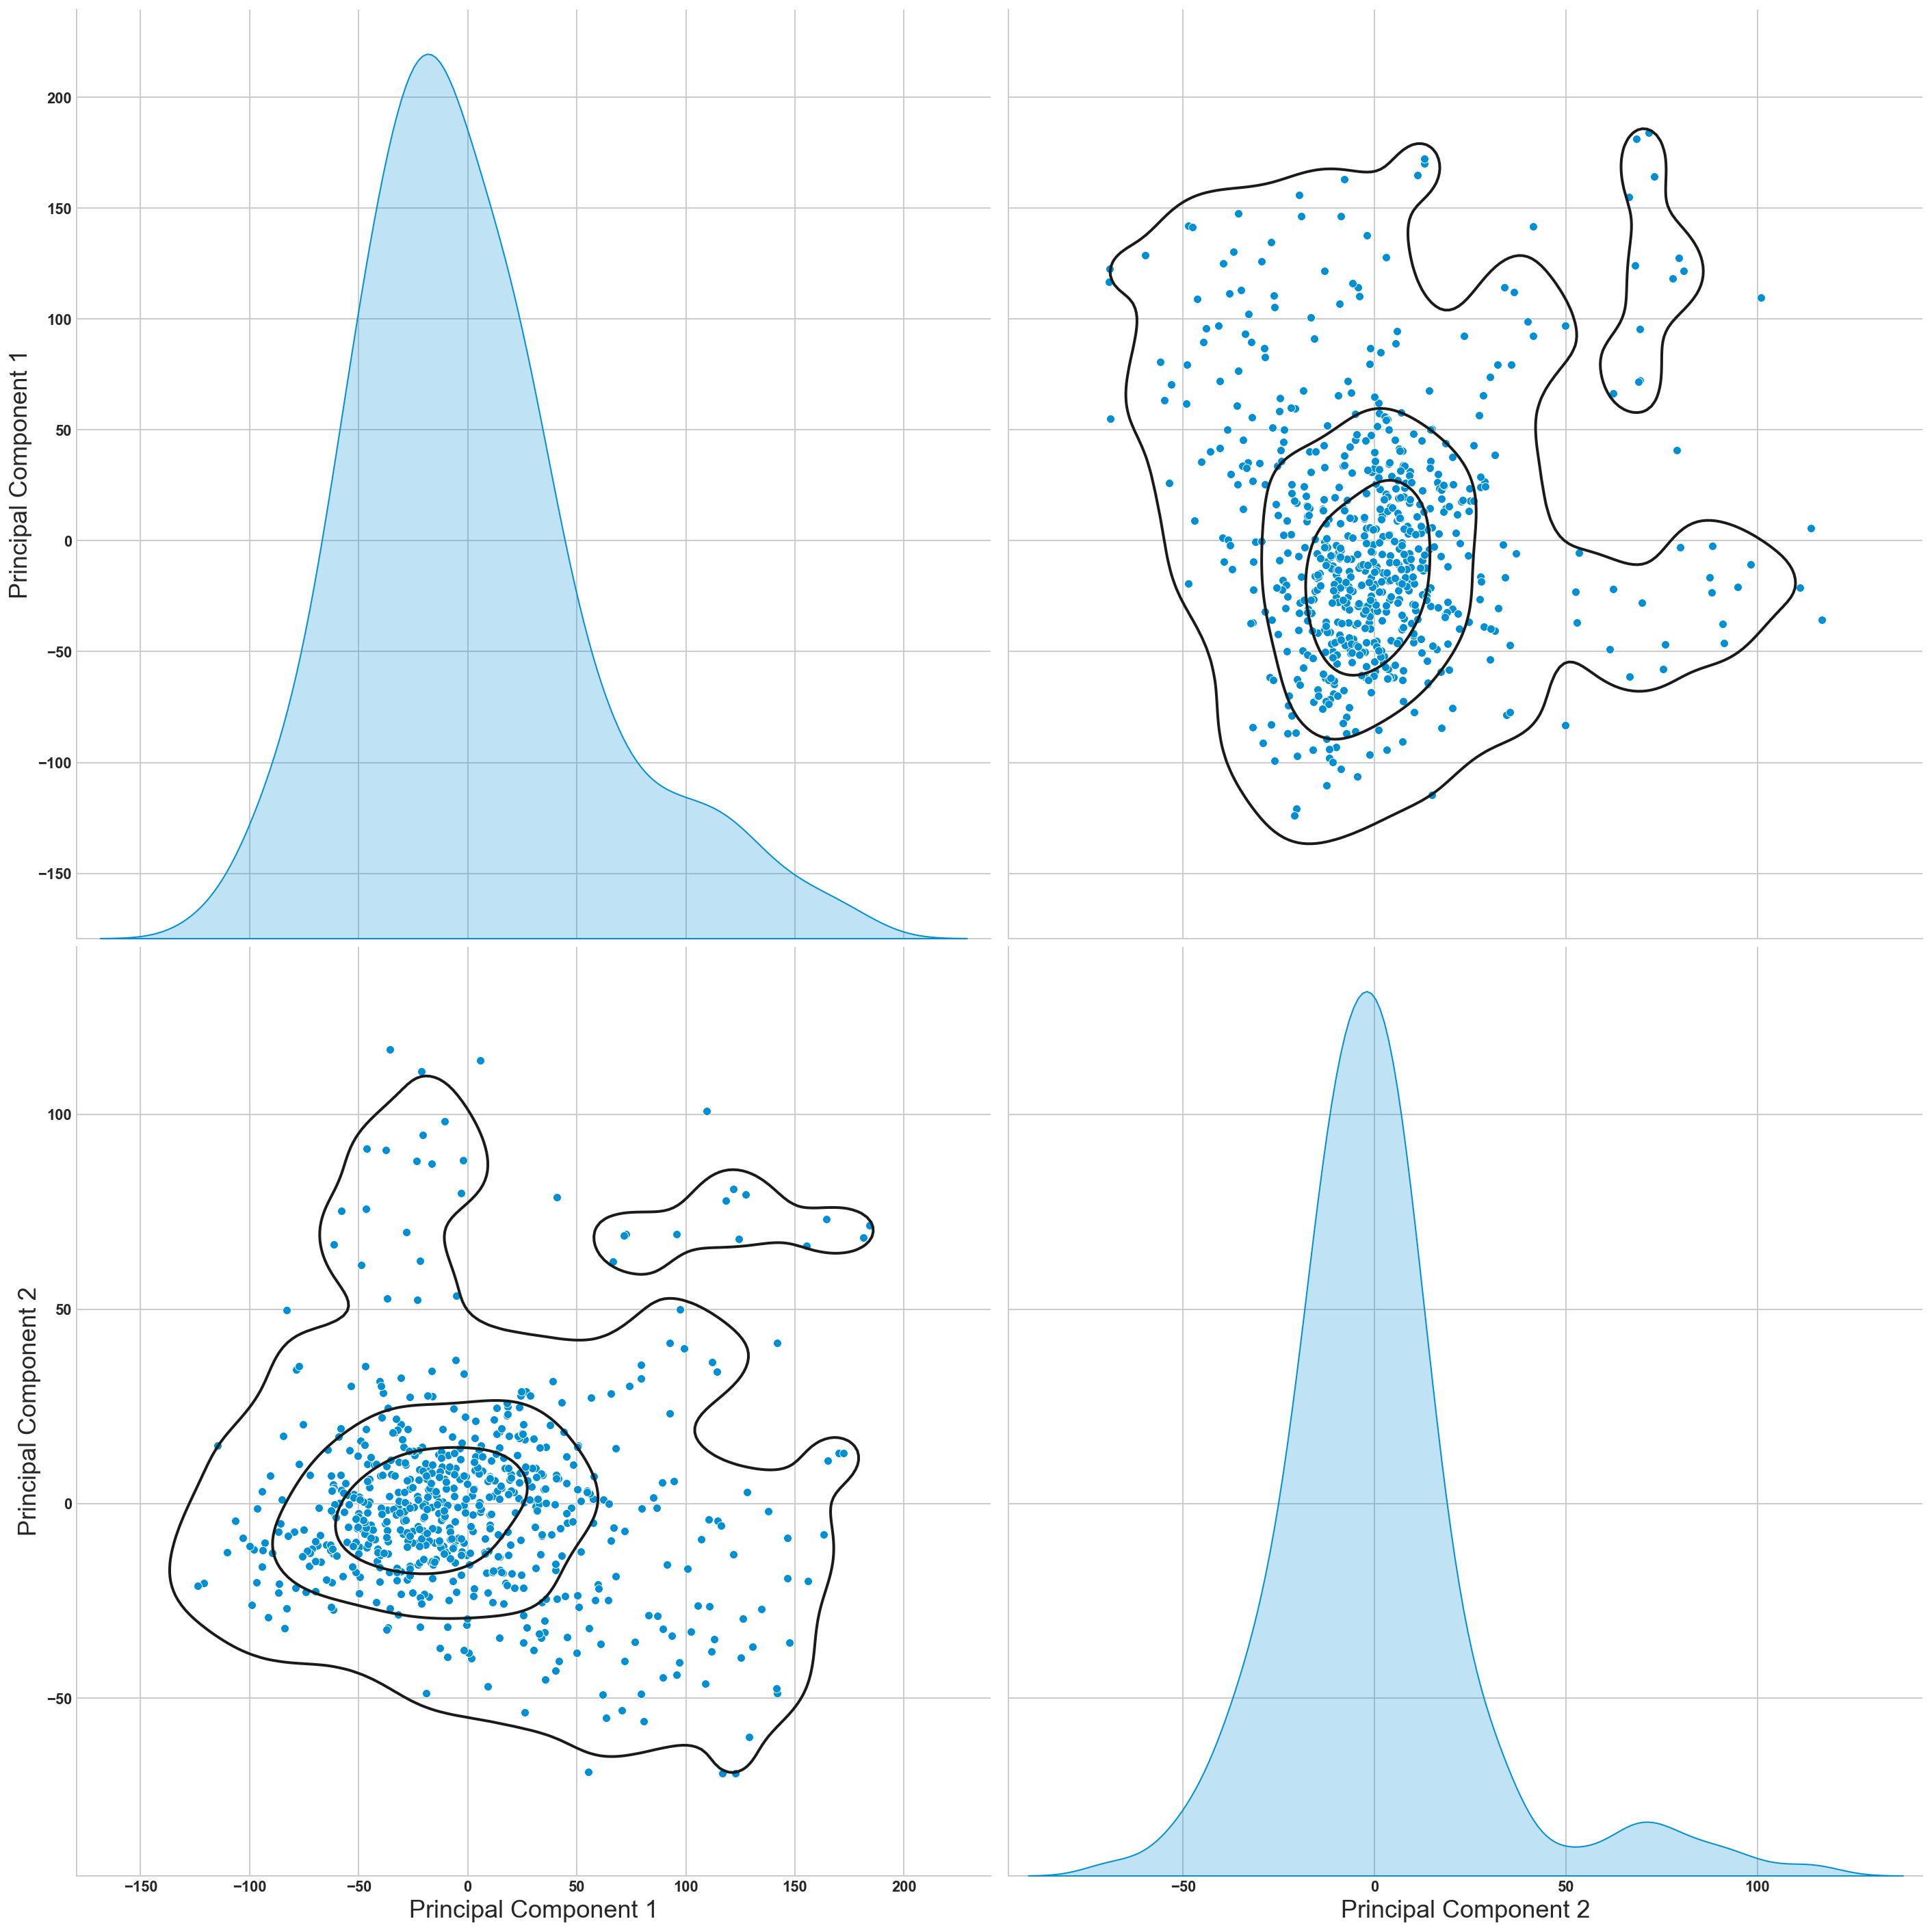

In [160]:
g = sns.pairplot(principalDf, size=10, diag_kind='kde')
g.map_offdiag(sns.kdeplot, levels=4, color='.1')

### Bar graph

In [50]:
from cv2 import resize

In [51]:
desktop = 'C:\\Users\\danny\\OneDrive\\Desktop\\'

In [52]:
img_path = desktop+'danaus.jpg'
new_image = plt.imread(img_path)

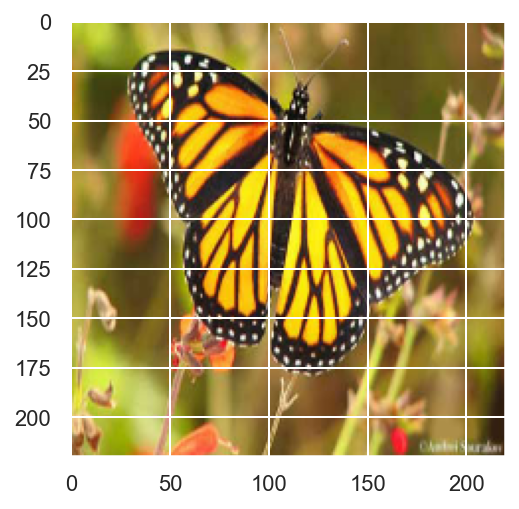

In [53]:
# Resize the image
resized_image = resize(new_image, img_shape[:2])
img = plt.imshow(resized_image)

In [54]:
# Get predictions
predictions = dense_model.predict(np.array([resized_image]))

# Show predictions
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [55]:
list_index = [0,1,2,3,4,5,6,7,8,9]
x = predictions

# Simple swapping function to sort the predictions least -> greatest
for i in range(10):
    for j in range(10):
        if x[0][list_index[i]] > x[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp
            
# labels in order
print(list_index)

[3, 1, 2, 0, 4, 5, 6, 7, 8, 9]


In [56]:
percentages = []
for i in range(10):
    percentages.append("{}: {}%".format(classification[list_index[i]],round(predictions[0][list_index[i]] * 100, 2)))

percentages

['Junonia coenia: 100.0%',
 'Heliconius charitonius: 0.0%',
 'Heliconius erato: 0.0%',
 'Danaus plexippus: 0.0%',
 'Lycaena phlaeas: 0.0%',
 'Nymphalis antiopa: 0.0%',
 'Papilio cresphontes: 0.0%',
 'Pieris rapae: 0.0%',
 'Vanessa atalanta: 0.0%',
 'Vanessa cardui: 0.0%']

In [57]:
percentage_only = []
for i in range(10):
    percent = round(predictions[0][list_index[i]] * 100, 2)
    percentage_only.append(percent)
    
    
type(percentage_only[1]), percentage_only

(numpy.float64, [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

<function matplotlib.pyplot.show(close=None, block=None)>

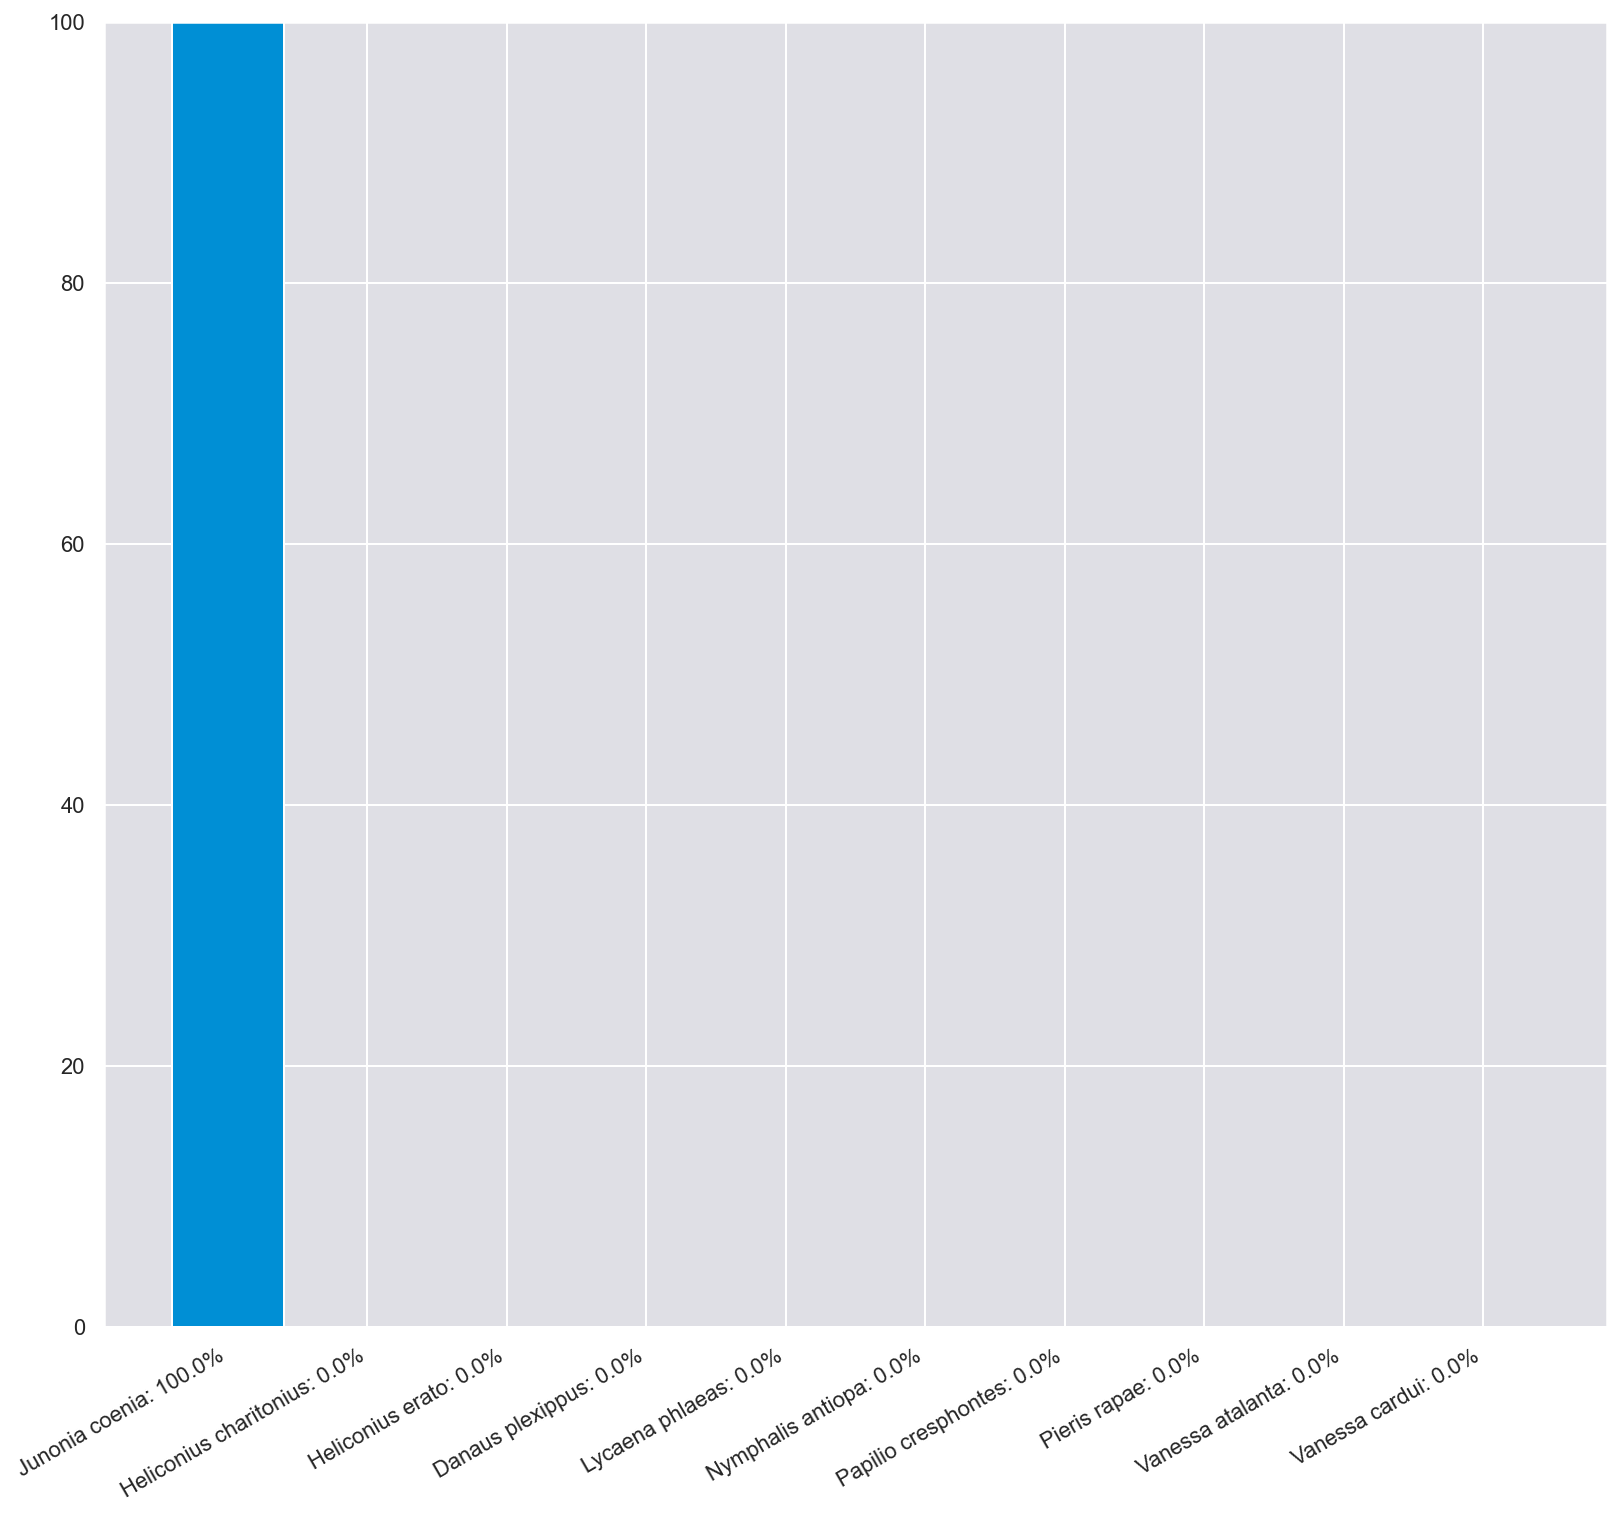

In [58]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)
font = {'family': 'normal',
        'weight': 'bold',
        'size': 44}

plt.rc('font', **font)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.ylim(0, 100)

ax.bar(percentages, percentage_only)

plt.show

### K-Means Clustering

In [161]:
from sklearn.cluster import KMeans

In [179]:
print(labels[75:85])

[1, 1, 1, 1, 1, 1, 1, 2, 2, 2]


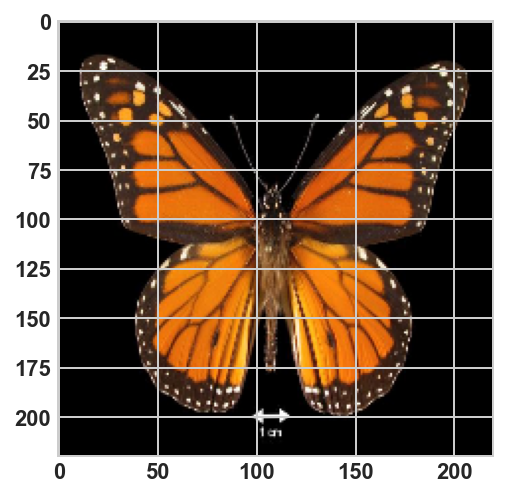

In [168]:
plt.imshow(images[1])

In [200]:
# images.shape, labels.shape

((832, 220, 220, 3), (832,))

In [185]:
# labels = np.array(labels)

In [186]:
# labels[75:85]

array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [162]:
kmeans = KMeans(n_clusters=2, random_state=0)

In [241]:
# flattened = train.shape[1] * images.shape[2] * images.shape[3]
# flattened

IndexError: tuple index out of range

In [204]:
# reshaped_images = images.reshape(-1, flattened)

In [205]:
# reshaped_images.shape

(832, 145200)

In [242]:
# clusters = kmeans.fit_predict(reshaped_images)

clusters = kmeans.fit_predict(train_x)

In [243]:
kmeans.cluster_centers_.shape

(2, 145200)

In [211]:
# scaler = StandardScaler()
# train_x = scaler.fit_transform(reshaped_images)
# test_x = scaler.fit_transform(y)

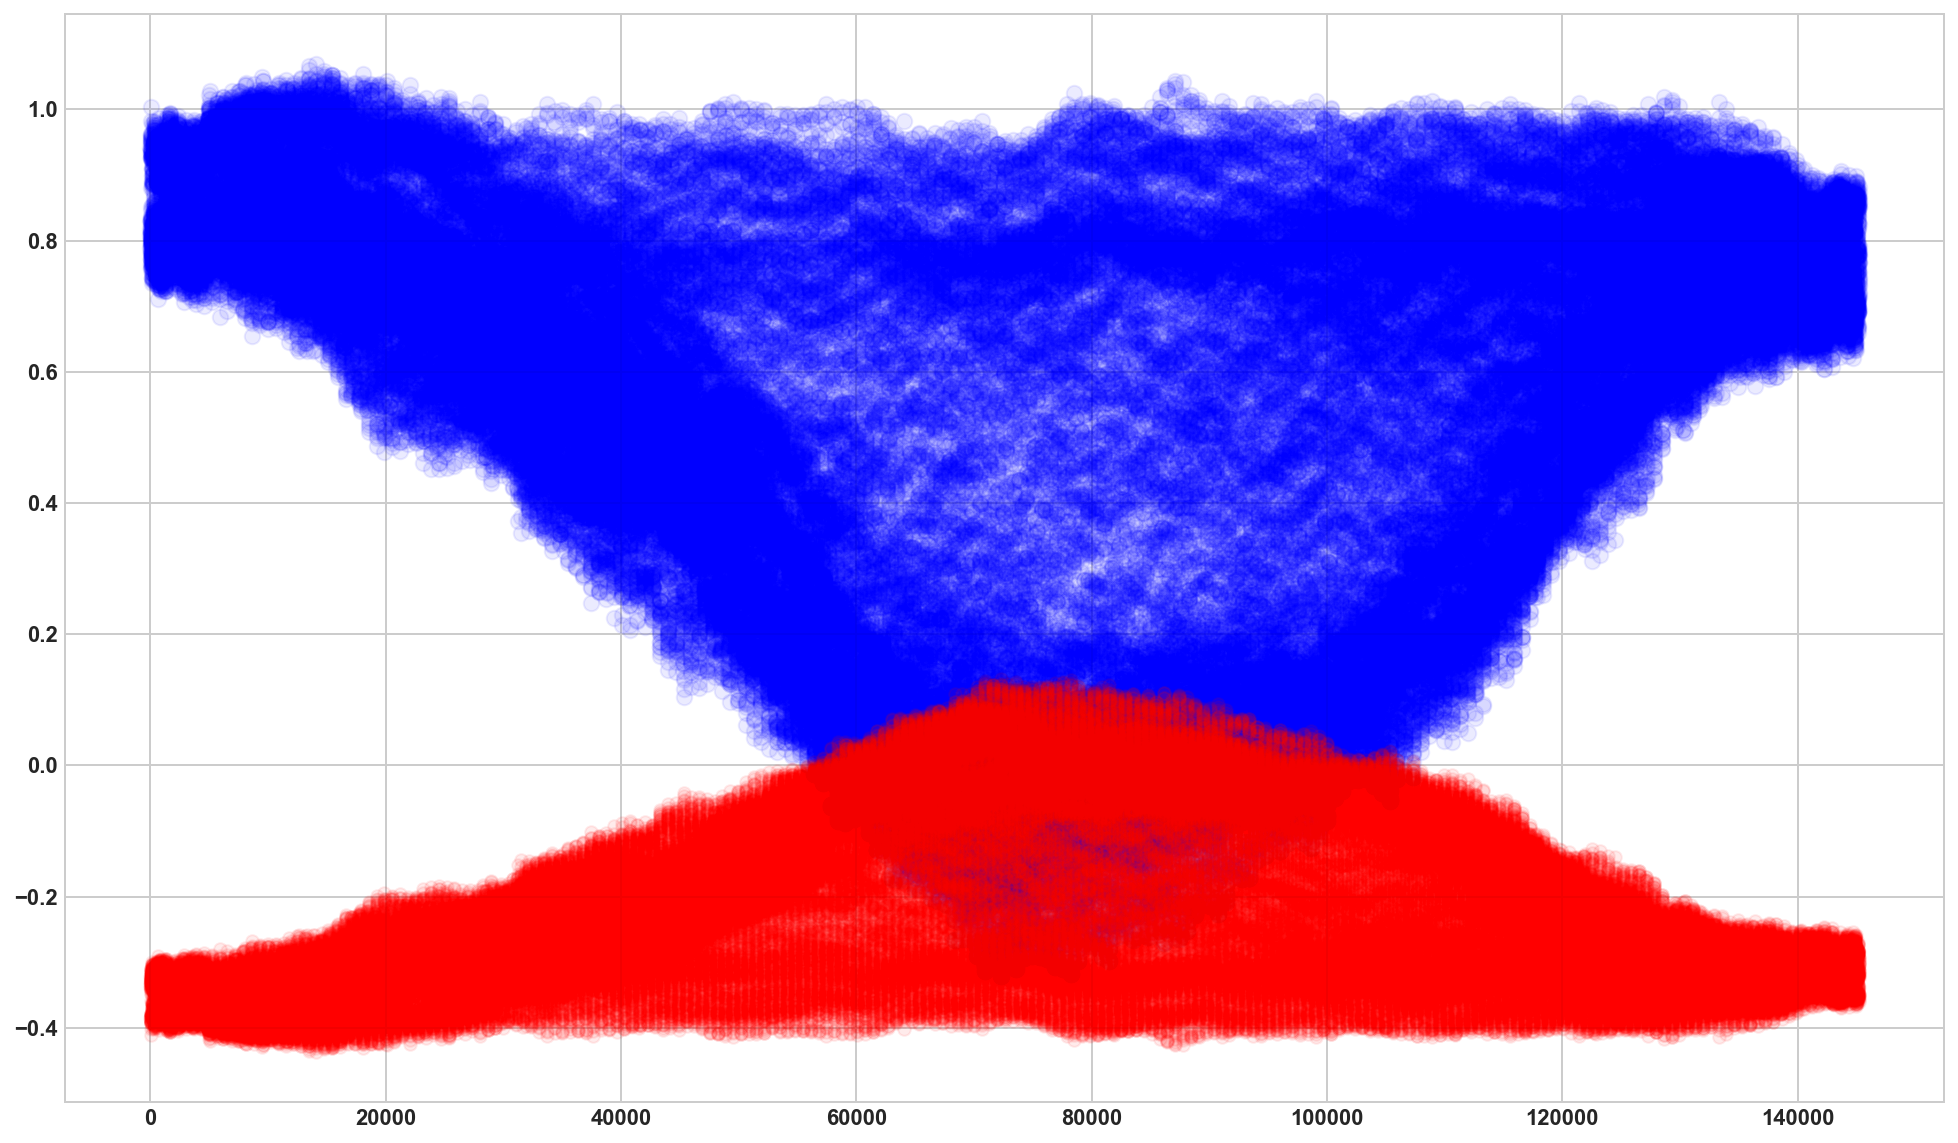

In [246]:
x_data = [i for i in range(145200)]
plt.figure(figsize=(15,10))
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'blue',alpha=0.08,s=60)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'red',alpha=0.08,s=40)